In [5]:
pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.9 MB/s eta 0:00:00


**1. Импорт библиотек**

In [16]:
#from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(DDGS().images(term, max_results=max_images)).itemgot('image')




import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search


**2. Предобработка данных**

In [28]:
urls = search_images('bird photos', max_images=1)
urls[0]
'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'

Searching for 'bird photos'


'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'

Загрузим URL и посмотрим, что получилось

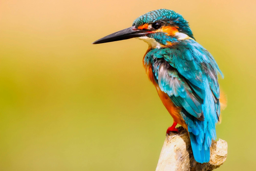

In [30]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


Проделаем такую же операцию для деревьев

Searching for 'forest photos'


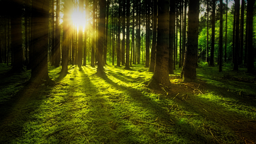

In [31]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Searching for 'cats photos'


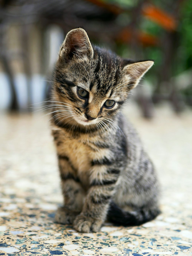

In [38]:
download_url(search_images('cats photos', max_images=1)[0], 'cats.jpg', show_progress=False)
Image.open('cats.jpg').to_thumb(256,256)

Необходимо взять по несколько изображений птиц и деревьев и сохранить каждую группу фотографий в другую папку

In [39]:
searches = 'forest','cats'
path = Path('cats_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo')) # диапазон освещения
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)


Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'cats photo'
Searching for 'cats sun photo'
Searching for 'cats shade photo'


**3. Обучение модели**

In [40]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


13

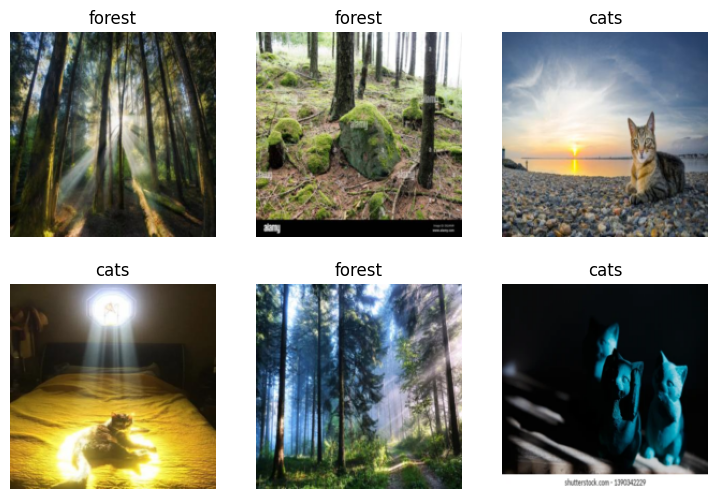

In [41]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


Обучение модели

In [43]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.077544,0.322939,0.100000,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.114107,0.060100,0.033333,00:20
1,0.090009,0.020730,0.000000,00:23
2,0.059617,0.017428,0.000000,00:23


In [47]:
is_cats,_,probs = learn.predict(PILImage.create('cats.jpg'))
print(f"This is a: {is_cats}.")
print(f"Probability it's a cats: {probs[0]:.4f}")
# Обманем модель
is_forest,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_forest}.")
print(f"Probability it's a forest: {probs[0]:.4f}")

This is a: cats.
Probability it's a cats: 1.0000


This is a: forest.
Probability it's a forest: 0.0002
